# Predict Sales

## Uploading data

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
from matplotlib import pyplot
import seaborn as sns
sns.set_theme(style="darkgrid")

from itertools import product

from datetime import datetime

from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,GRU,InputLayer
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv(r'predict_sales/data/sales_train.csv')
test = pd.read_csv(r'predict_sales/data/test.csv')
items = pd.read_csv(r'predict_sales/data/items.csv')
item_categories = pd.read_csv(r'predict_sales/data/item_categories.csv')
shops = pd.read_csv(r'predict_sales/data//shops.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train['date'] = pd.to_datetime(train['date'])

In [5]:
train['dayofweek'] = train['date'].dt.dayofweek

train = train.join(items, on='item_id', rsuffix='_pr')
train.drop(columns=['item_id_pr'], inplace=True)

In [6]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [7]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


## Exploratory Analysis and Data Cleaning

In [10]:
print('Amount of items: ' + str(items.shape))
print('Amount of shops: ' + str(shops.shape))
print('Amount of categories: ' + str(item_categories.shape))

Amount of items: (22170, 3)
Amount of shops: (60, 2)
Amount of categories: (84, 2)


In [11]:
len(test['shop_id'].unique())

42

In [12]:
test['shop_id'].unique()

array([ 5,  4,  6,  3,  2,  7, 10, 12, 28, 31, 26, 25, 22, 24, 21, 15, 16,
       18, 14, 19, 42, 50, 49, 53, 52, 47, 48, 57, 58, 59, 55, 56, 36, 37,
       35, 38, 34, 46, 41, 44, 39, 45], dtype=int64)

In [13]:
len(test['item_id'].unique())

5100

Not every shop's and item's sales must be forecasted.

In [14]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,3.235982e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,2.009566e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,3.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,6.000000e+00,8.300000e+01


**There are negative item_price and item_cnt_day**

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,item_name,item_category_id
484683,2013-05-15,4,32,2973,-1.0,1.0,2,"DmC Devil May Cry [PS3, русские субтитры]",19


Replacing it's with mean price for this item

In [16]:
train.at[484683, 'item_price'] = train.loc[train['item_id'] == 2973, 'item_price'].mean()

In [17]:
train[train['item_cnt_day'] < 0].shape

(7356, 9)

Replacing 'item_cnt_day' < 0 with 0

In [18]:
train.loc[train['item_cnt_day'] < 0, 'item_cnt_day'] = 0

In [19]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908539e+02,1.245209e+00,3.235982e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.617046e+00,2.009566e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,3.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,6.000000e+00,8.300000e+01


**We'll handle outliers differently for different approaches**

**Handling duplicates**

In [20]:
train[train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,item_name,item_category_id
76962,2013-05-01,0,54,20130,149.0,1.0,2,УЧЕНИК ЧАРОДЕЯ (регион),40
1435367,2014-02-23,13,50,3423,999.0,1.0,6,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
1496766,2014-03-23,14,21,3423,999.0,1.0,6,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
1671873,2014-01-05,16,50,3423,999.0,1.0,6,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
1866340,2014-12-07,18,25,3423,999.0,1.0,6,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23
2198566,2014-12-31,23,42,21619,499.0,1.0,2,ЧЕЛОВЕК ДОЖДЯ (BD),37


In [21]:
train.drop(train[train.duplicated() == True].index, inplace=True)

### Sales graphs

In [22]:
shop_items_day = train.groupby(['shop_id', 'date']).sum().sort_values(by=['date'])
shop_items_month = train.groupby(['shop_id', 'date_block_num']).sum().sort_values(by=['date_block_num'])

#### Sales graph for company

In [23]:
comp_items_month = train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'})

In [24]:
comp_items_day = train.groupby(['date']).agg({'item_cnt_day': 'sum'})
comp_items_day['dayofweek'] = comp_items_day.index.get_level_values('date').dayofweek
comp_items_day['month'] = comp_items_day.index.get_level_values('date').month

**By day**

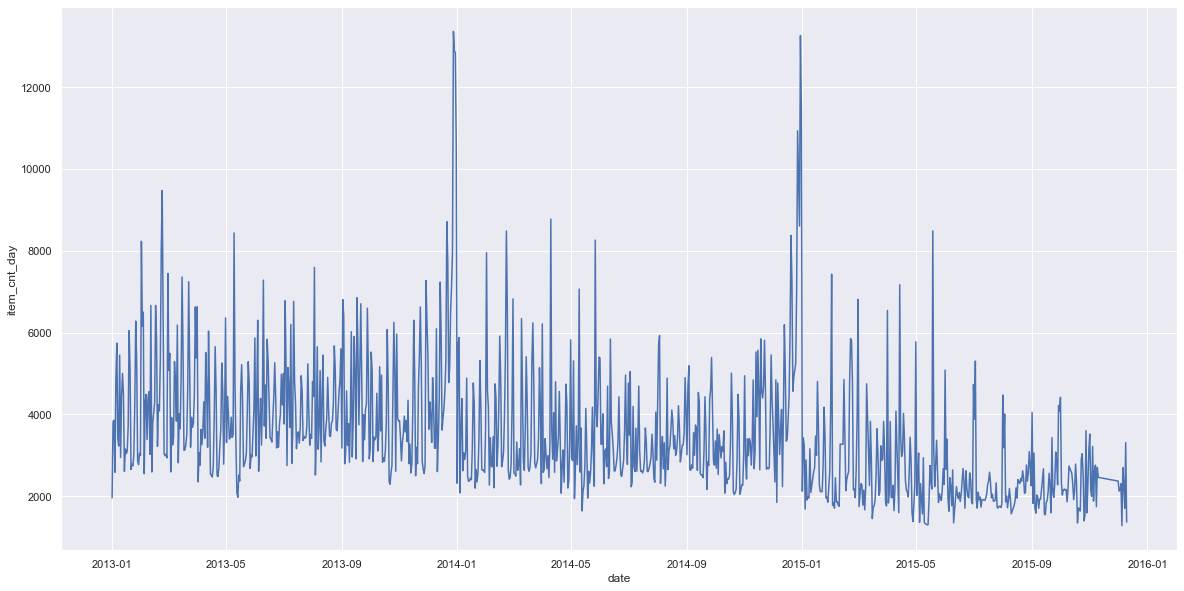

In [25]:
fig, ax = pyplot.subplots(figsize=(20, 10))
sns.lineplot(ax = ax, x='date', y='item_cnt_day',
             data=comp_items_day.sort_values(by=['date']))

**By month**

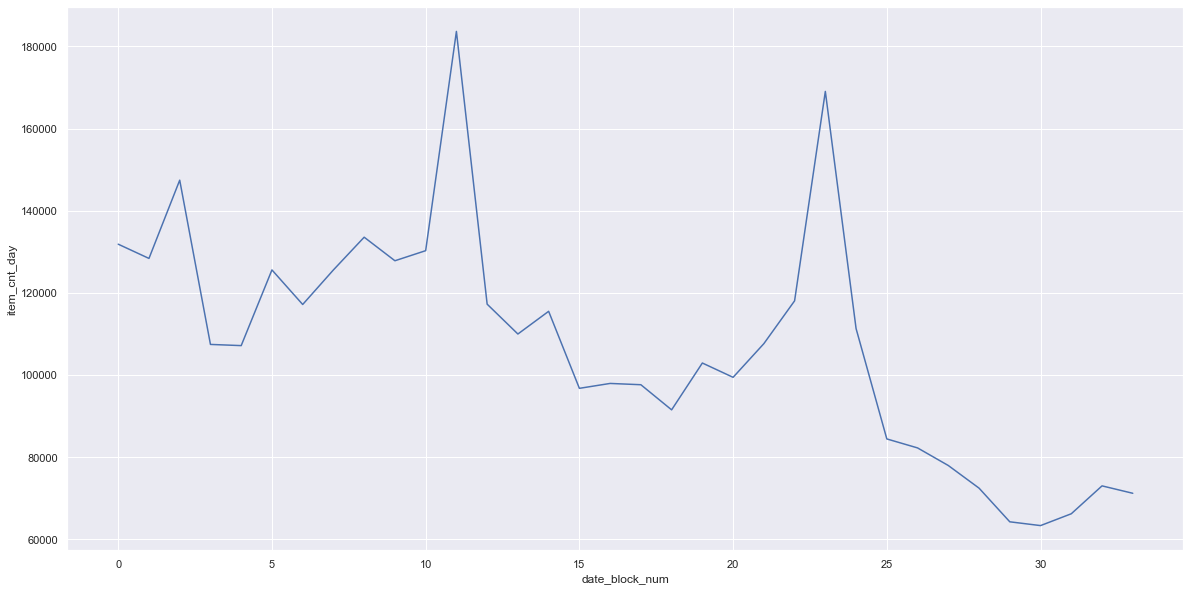

In [26]:
fig, ax = pyplot.subplots(figsize=(20, 10))
sns.lineplot(ax = ax, x='date_block_num', y='item_cnt_day',
             data=comp_items_month.sort_values(by=['date_block_num']))

**By day of week**

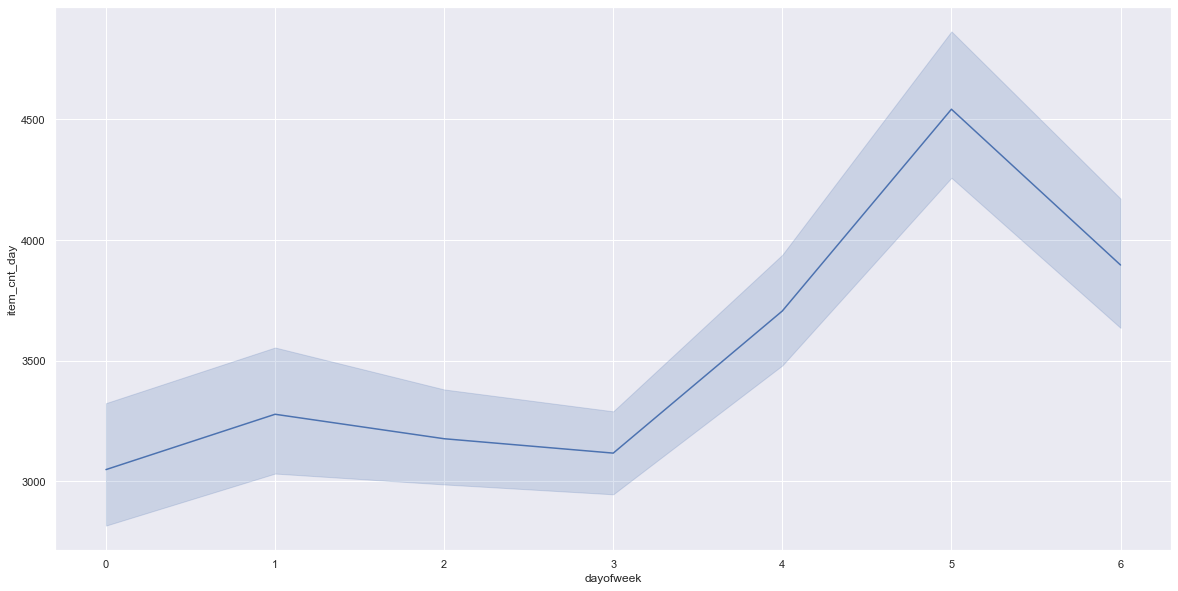

In [27]:
fig, ax = pyplot.subplots(figsize=(20, 10))
sns.lineplot(ax = ax, x='dayofweek', y='item_cnt_day',
             data=comp_items_day.sort_values(by=['date']))

**By number of month**

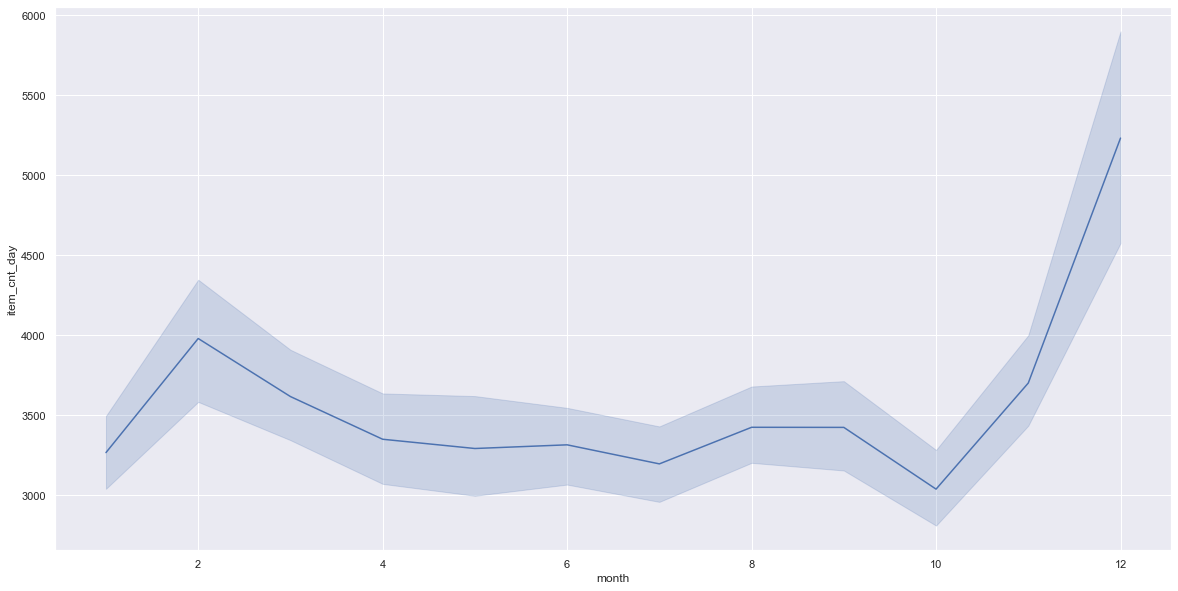

In [28]:
fig, ax = pyplot.subplots(figsize=(20, 10))
sns.lineplot(ax = ax, x='month', y='item_cnt_day',
             data=comp_items_day.sort_values(by=['date']))

**There is a trend of sales decreasing through time and seasonality (boom in the end of the year). Also there's a weekly seasonality**

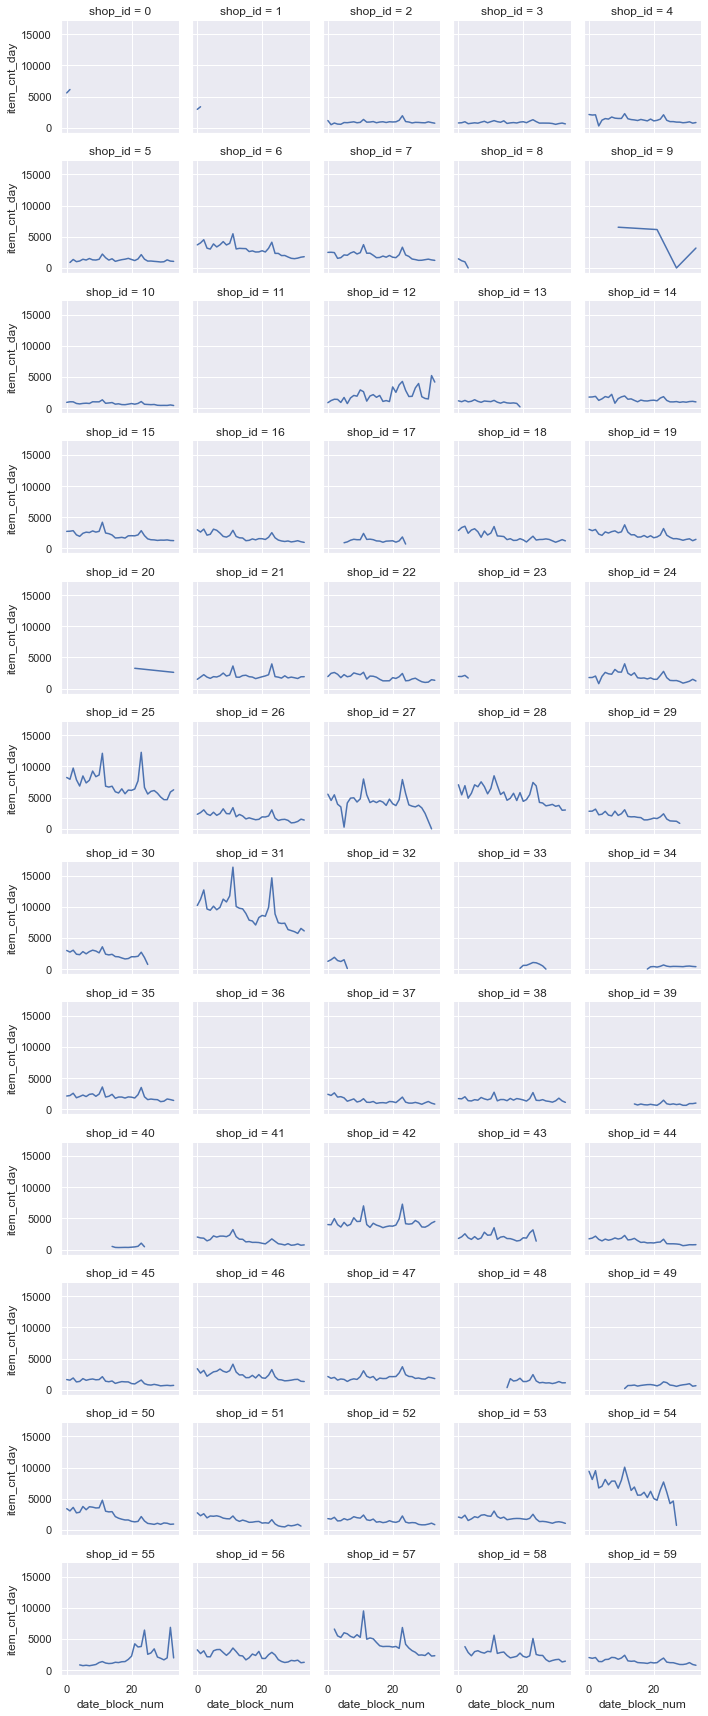

In [29]:
g = sns.FacetGrid(shop_items_month.reset_index(), col='shop_id', height=2, col_wrap=5)
g.map(sns.lineplot, 'date_block_num', 'item_cnt_day')

**All representive shops (without information being interrupted) seems to confirm the seasonality and trend of decreasing, except for shop 55 and 12**

In [30]:
shops[shops['shop_id'] == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


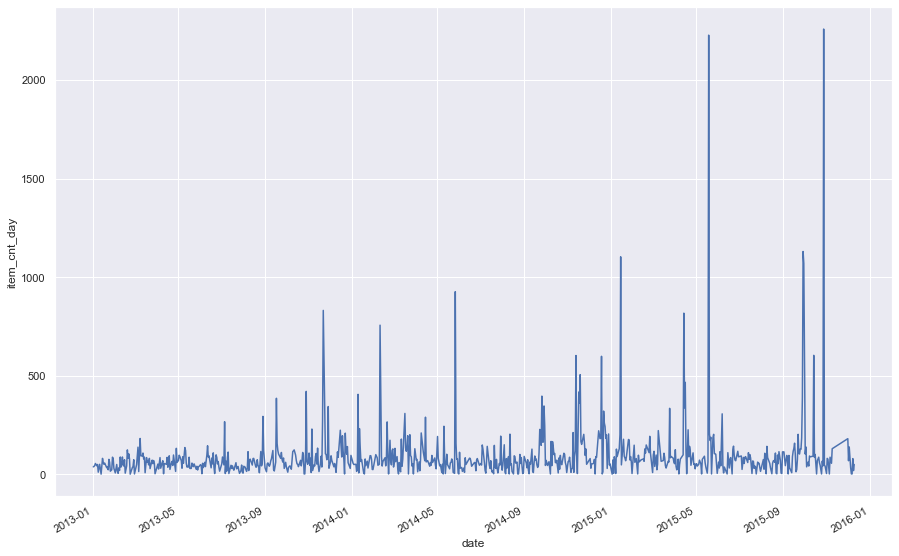

In [31]:
fig, ax = pyplot.subplots(figsize=(15, 10))
ax.xaxis_date()
fig.autofmt_xdate()
sns.lineplot(ax = ax, x='date', y='item_cnt_day',
             data=shop_items_day[shop_items_day.index.get_level_values('shop_id') == 12].sort_values(by=['date']))

In [32]:
shops[shops['shop_id'] == 55]

,shop_name,shop_id
55,Цифровой склад 1С-Онлайн,55


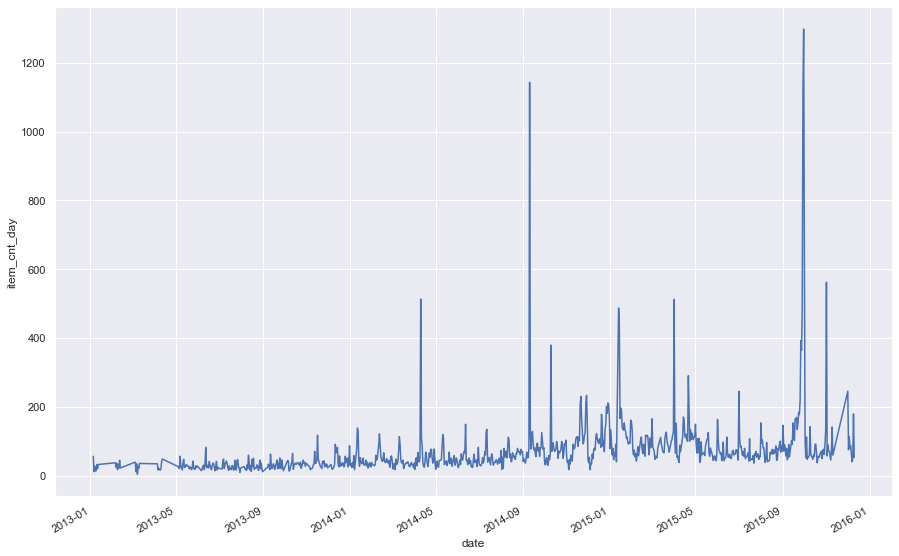

In [33]:
fig, ax = pyplot.subplots(figsize=(15, 10))
ax.xaxis_date()
fig.autofmt_xdate()
sns.lineplot(ax = ax, x='date', y='item_cnt_day',
             data=shop_items_day[shop_items_day.index.get_level_values('shop_id') == 55].sort_values(by=['date']))

**Both shops are online (the last one is a warehouse) so that can explain their deviation.**

#### Sales graphs for categories

In [34]:
items['item_category_id'].value_counts()

40    5035
55    2365
37    1780
31    1125
58     790
      ... 
50       2
1        2
51       1
10       1
79       1
Name: item_category_id, Length: 84, dtype: int64

In [35]:
categories_items_day = train.groupby(['item_category_id', 'date']).sum()
categories_items_month = train.groupby(['item_category_id', 'date_block_num']).sum()

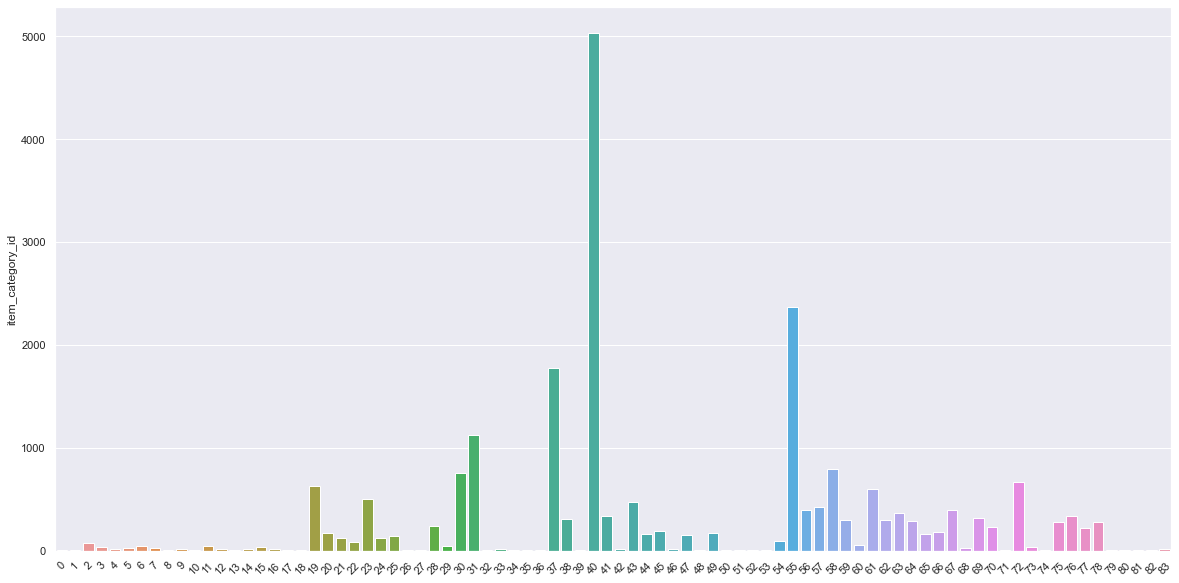

In [36]:
fig, ax = pyplot.subplots(figsize=(20, 10))
pyplot.xticks(rotation=45)
sns.barplot(ax=ax, x=items['item_category_id'].value_counts().index, y=items['item_category_id'].value_counts())

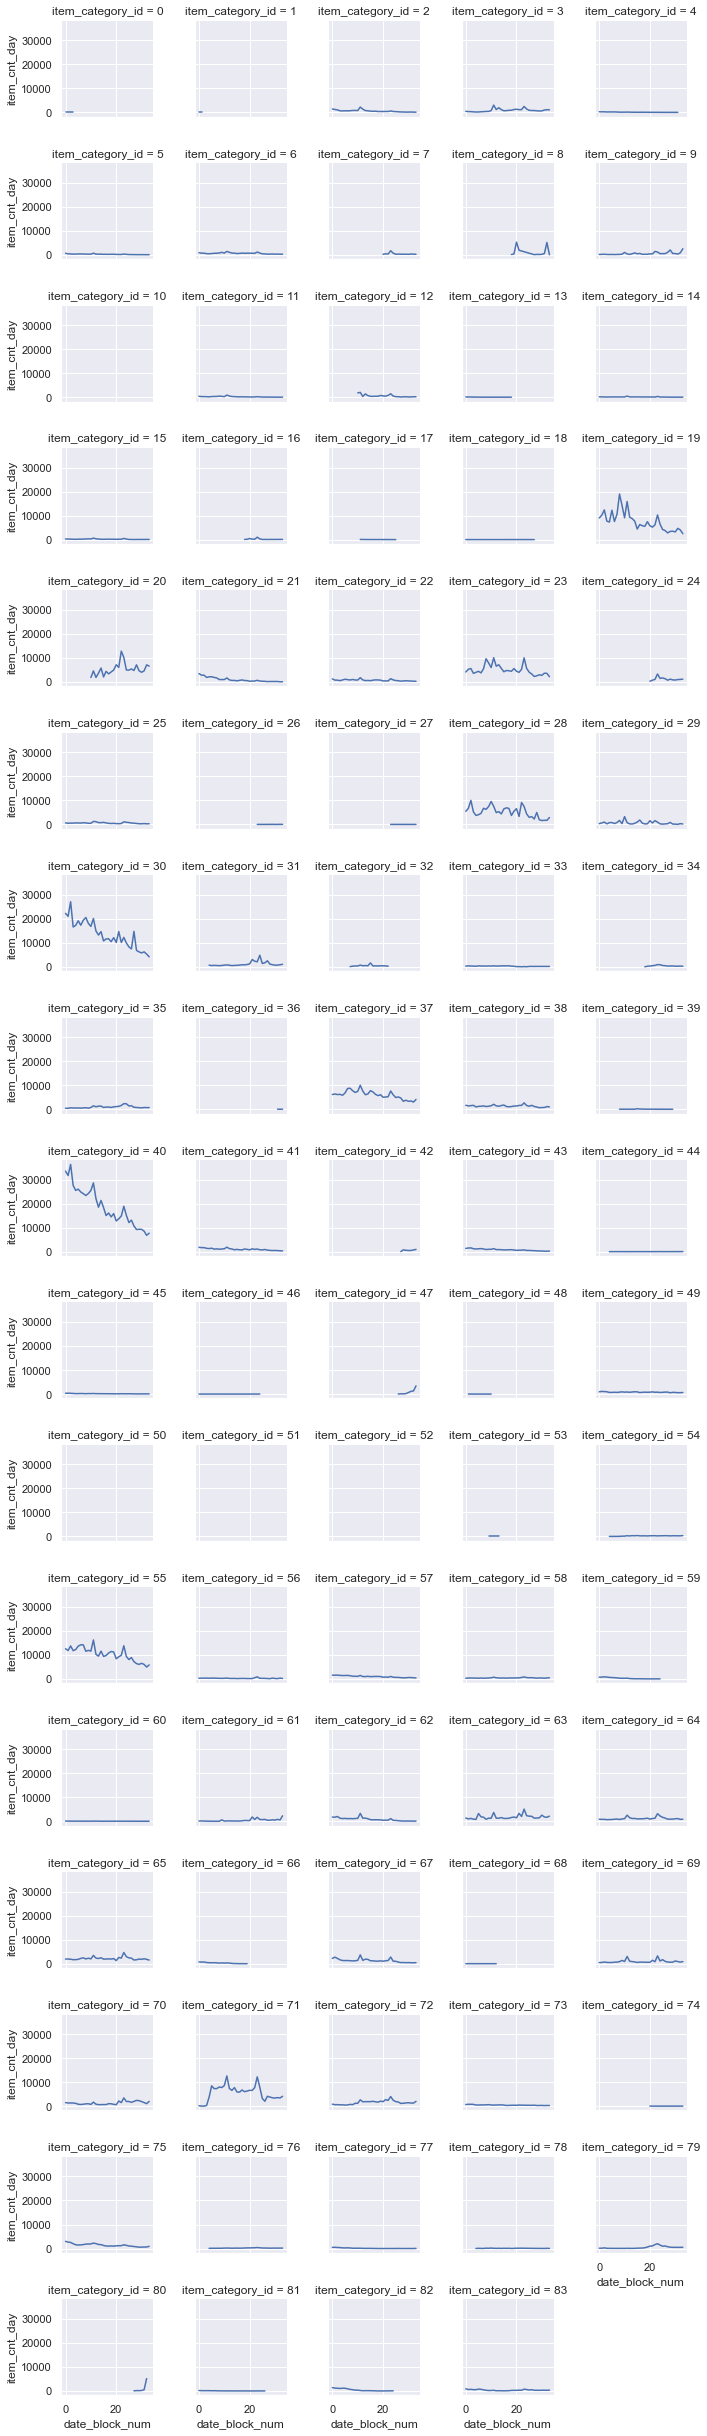

In [37]:
g = sns.FacetGrid(categories_items_month.reset_index().sort_values(by=['date_block_num']),
                  col='item_category_id', height=2, col_wrap=5)
g.map(sns.lineplot, 'date_block_num', 'item_cnt_day')

**Most of categories are not represented widely, but seem to repeat general seasonality. 
However, some of the most popular categories (id=40 and 30) seem to have a trend of decreasing, but the seasonality (if it actually exist) doesn't repeat common for all items**

In [38]:
item_categories.iloc[30]

item_category_name    Игры PC - Стандартные издания
item_category_id                                 30
Name: 30, dtype: object

In [39]:
item_categories.iloc[40]

item_category_name    Кино - DVD
item_category_id              40
Name: 40, dtype: object

**These two categories are 'PC Games' and 'DVD Movies'. So we can suggest that spikes in sales we see are due to the release of a new game or movie. Overall decreasing trend is probably caused by decreasing demand in physical media (DVD, CD etc.)**

**3 most popular category:**

In [40]:
print(item_categories.iloc[40].item_category_name)
print(item_categories.iloc[55].item_category_name)
print(item_categories.iloc[31].item_category_name)

Кино - DVD
Музыка - CD локального производства
Игры PC - Цифра


**All of them are physical media. That explains the overall drop in sales.**

### Dependence of price on sales

In [41]:
items_day = train.groupby(['item_id', 'date']).agg({'item_price':'mean', 'item_cnt_day': 'sum'})
items_month = train.groupby(['item_id', 'date_block_num']).agg({'item_price':'mean', 'item_cnt_day': 'sum'})
items_count = train.groupby(['item_id']).sum()['item_cnt_day']

In [42]:
top_items_count= items_count.sort_values(ascending=False).index[:20]

In [43]:
top_items_month = items_month[np.isin(items_month.index.get_level_values('item_id'), top_items_count)]

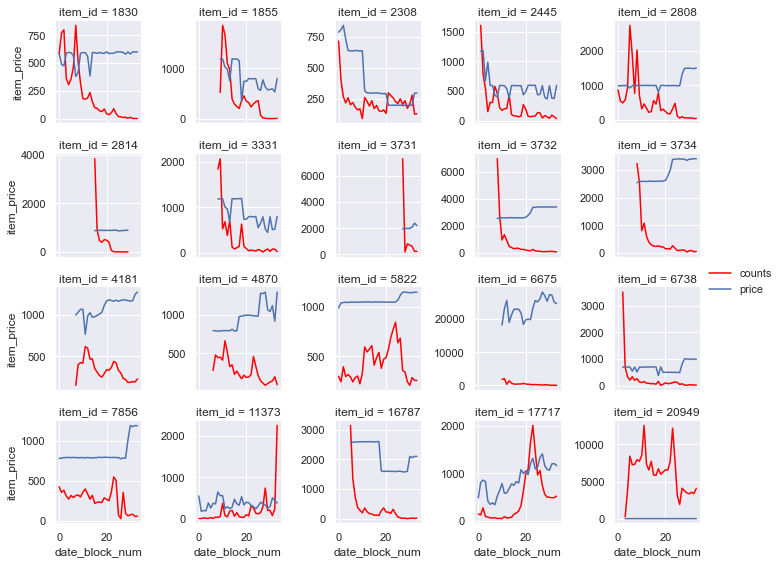

In [44]:
g = sns.FacetGrid(top_items_month.reset_index().sort_values(by=['date_block_num']),
                  col='item_id', height=2, col_wrap=5, sharey=False, sharex=True)
g.map(sns.lineplot, 'date_block_num', 'item_cnt_day', color = 'red', label='counts')
g.map(sns.lineplot, 'date_block_num', 'item_price', label='price')
g.add_legend()

In [45]:
print(items[items['item_id'] == 1830]['item_name'])
print(items[items['item_id'] == 2308]['item_name'])
print(items[items['item_id'] == 11373]['item_name'])
print(items[items['item_id'] == 20949]['item_name'])
print(items[items['item_id'] == 5822]['item_name'])
print(items[items['item_id'] == 17717]['item_name'])

1830    Battlefield 3 [PC, Jewel, русская версия]
Name: item_name, dtype: object
2308    Call of Duty: Black Ops II [PС, Jewel, русская...
Name: item_name, dtype: object
11373    Доставка до пункта выдачи (Boxberry)
Name: item_name, dtype: object
20949    Фирменный пакет майка 1С Интерес белый (34*42)...
Name: item_name, dtype: object
5822    Playstation Store пополнение бумажника: Карта ...
Name: item_name, dtype: object
17717    Прием денежных средств для 1С-Онлайн
Name: item_name, dtype: object


**There is no visible correlation of price with sales.**

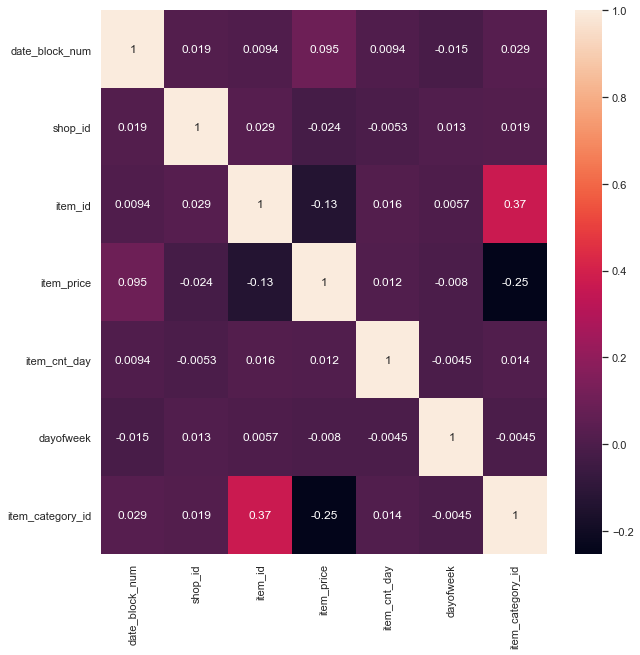

In [46]:
fig, ax = pyplot.subplots(figsize=(10, 10))
sns.heatmap(train.corr(), annot=True)

## LSTM / GRU approach

### Outliers  handing

In [47]:
train['item_cnt_day'].describe()

count    2.935843e+06
mean     1.245210e+00
std      2.617049e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [48]:
train['item_cnt_day'] = train['item_cnt_day'].astype('float32')

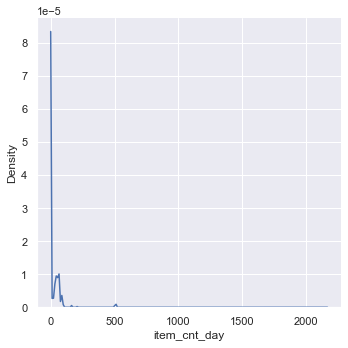

In [49]:
sns.displot(x=train['item_cnt_day'], kind='kde')

In [50]:
train.loc[train['item_cnt_day'] > 20, 'item_cnt_day'] = 20

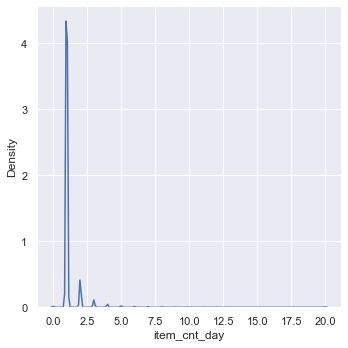

In [51]:
sns.displot(x=train['item_cnt_day'], kind='kde')

**We'll use the last 12 months before the target and validation set to tune hyperparameters**

In [52]:
NN_train_tune = train[train['date_block_num'] > 20].groupby(['item_id', 'shop_id',
                                                          'date_block_num']).agg({'item_cnt_day': 
                                                                                  'sum'}).sort_values(by='date_block_num')
NN_train = train[train['date_block_num'] > 19].groupby(['item_id', 'shop_id',
                                                          'date_block_num']).agg({'item_cnt_day': 
                                                                                  'sum'}).sort_values(by='date_block_num')

In [53]:
NN_train.reset_index(inplace=True)
NN_train_tune.reset_index(inplace=True)

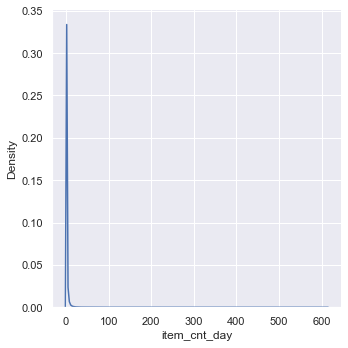

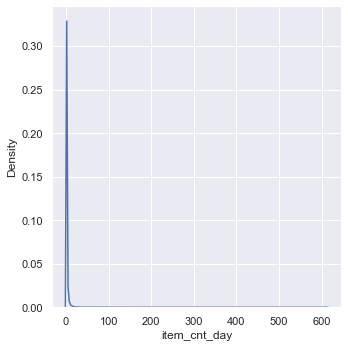

In [54]:
sns.displot(x=NN_train['item_cnt_day'], kind='kde')
sns.displot(x=NN_train_tune['item_cnt_day'], kind='kde')

In [55]:
NN_train = NN_train.pivot_table(index=['item_id', 'shop_id'], columns=['date_block_num'], values=['item_cnt_day'])
NN_train_tune = NN_train_tune.pivot_table(index=['item_id', 'shop_id'], columns=['date_block_num'], values=['item_cnt_day'])

In [56]:
NN_train.reset_index(inplace=True)
NN_train_tune.reset_index(inplace=True)

In [57]:
NN_train = pd.merge(test, NN_train, on=['item_id', 'shop_id'], how='left')
NN_train_tune = pd.merge(test, NN_train_tune, on=['item_id', 'shop_id'], how='left')

C:\ProgramData\Anaconda3_1\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3_1\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [58]:
print(NN_train.shape)
print(NN_train_tune.shape)
print(test.shape)

(214200, 17)
(214200, 16)
(214200, 3)


### Missing values

In [59]:
NN_train.fillna(0, inplace=True)
NN_train_tune.fillna(0, inplace=True)

### Building a model

**Training on 32th month, validating on 33th. After tuning use X_valid and Y_valid to train our model to predict 34th month**

In [60]:
X_train = NN_train.iloc[:, 3:-2].values.reshape(214200, 12, 1)
Y_train = NN_train.iloc[:, -2:-1].values.reshape(214200, 1)

X_valid = NN_train_tune.iloc[:, 3:-1].values.reshape(214200, 12, 1)
Y_valid = NN_train_tune.iloc[:, -1:].values.reshape(214200, 1)

X_test = NN_train_tune.iloc[:, 4:].values.reshape(214200, 12, 1)

In [61]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape)

(214200, 12, 1) (214200, 1)
(214200, 12, 1) (214200, 1)
(214200, 12, 1)


#### LSTM

In [62]:
def create_LSTM():
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(units = 64, input_shape=(12,1)))
    LSTM_model.add(Dropout(0.3))
    LSTM_model.add(Dense(32, activation='relu'))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(loss = 'mse',optimizer = 'adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    LSTM_model.summary()
    return LSTM_model

In [63]:
tune_LSTM = create_LSTM()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________


In [64]:
history = tune_LSTM.fit(X_train,Y_train, batch_size=4000, epochs = 20, validation_data=(X_valid, Y_valid))

Epoch 1/20
54/54 [==============================] - 21s 344ms/step - loss: 3.4134 - rmse: 1.8240 - val_loss: 4.9434 - val_rmse: 2.2234
Epoch 2/20
54/54 [==============================] - 16s 296ms/step - loss: 3.2700 - rmse: 1.7896 - val_loss: 4.4820 - val_rmse: 2.1171
Epoch 3/20
54/54 [==============================] - 16s 295ms/step - loss: 4.8745 - rmse: 2.1838 - val_loss: 4.2157 - val_rmse: 2.0532
Epoch 4/20
54/54 [==============================] - 16s 297ms/step - loss: 4.0569 - rmse: 1.9839 - val_loss: 3.9847 - val_rmse: 1.9962
Epoch 5/20
54/54 [==============================] - 16s 292ms/step - loss: 4.0111 - rmse: 1.9726 - val_loss: 3.8244 - val_rmse: 1.9556
Epoch 6/20
54/54 [==============================] - 15s 285ms/step - loss: 4.1918 - rmse: 2.0006 - val_loss: 3.7122 - val_rmse: 1.9267
Epoch 7/20
54/54 [==============================] - 16s 293ms/step - loss: 3.7178 - rmse: 1.9083 - val_loss: 3.6263 - val_rmse: 1.9043
Epoch 8/20
54/54 [==============================] - 15s

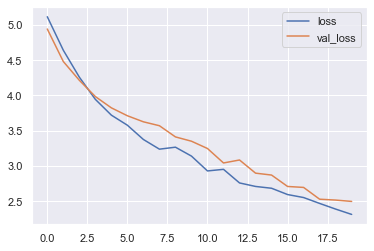

In [65]:
sns.lineplot(data = history.history['loss'], label='loss')
sns.lineplot(data = history.history['val_loss'], label='val_loss')

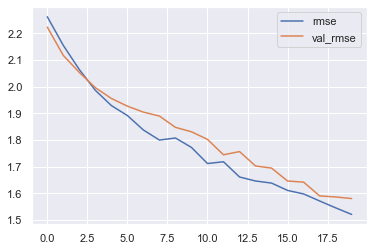

In [66]:
sns.lineplot(data = history.history['rmse'], label='rmse')
sns.lineplot(data = history.history['val_rmse'], label='val_rmse')

In [67]:
print('LSTM')
print('mse - ' + str(min(history.history['val_loss'])))
print('rmse - ' + str(min(history.history['val_rmse'])))

LSTM
mse - 2.4962706565856934
rmse - 1.5799590349197388


In [68]:
LSTM_model = create_LSTM()
history = LSTM_model.fit(X_valid, Y_valid, batch_size=4000, epochs = 20)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
54/54 [==============================] - 15s 236ms/step - loss: 5.0675 - rmse: 2.2351
Epoch 2/20
54/54 [==============================] - 13s 238ms/step - loss: 3.6502 - rmse: 1.8862
Epoch 3/20
54/54 [==============================] - 14

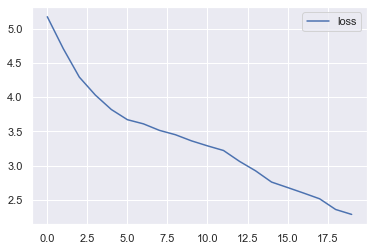

In [69]:
sns.lineplot(data = history.history['loss'], label='loss')

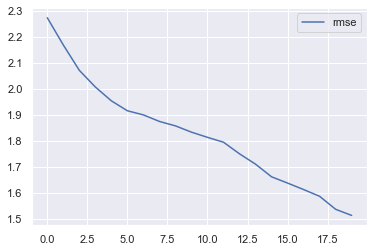

In [70]:
sns.lineplot(data = history.history['rmse'], label='rmse')

In [71]:
LSTM_y = LSTM_model.predict(X_test)

#### GRU

In [72]:
def create_GRU():
    GRU_model = Sequential()
    GRU_model.add(GRU(units = 64, input_shape=(12,1)))
    GRU_model.add(Dropout(0.3))
    GRU_model.add(Dense(32, activation='relu'))
    GRU_model.add(Dense(1))
    GRU_model.compile(loss = 'mse',optimizer = 'adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    GRU_model.summary()
    return GRU_model

In [73]:
GRU_tune = create_GRU()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 64)                12864     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 14,977
Trainable params: 14,977
Non-trainable params: 0
_________________________________________________________________


In [74]:
history_GRU = GRU_tune.fit(X_train, Y_train, batch_size=4000, epochs = 20, validation_data=(X_valid, Y_valid))

Epoch 1/20
54/54 [==============================] - 18s 285ms/step - loss: 6.2837 - rmse: 2.4855 - val_loss: 4.9305 - val_rmse: 2.2205
Epoch 2/20
54/54 [==============================] - 15s 272ms/step - loss: 3.9086 - rmse: 1.9653 - val_loss: 4.6573 - val_rmse: 2.1581
Epoch 3/20
54/54 [==============================] - 15s 271ms/step - loss: 4.1581 - rmse: 2.0239 - val_loss: 4.3403 - val_rmse: 2.0833
Epoch 4/20
54/54 [==============================] - 16s 291ms/step - loss: 4.3568 - rmse: 2.0633 - val_loss: 4.0946 - val_rmse: 2.0235
Epoch 5/20
54/54 [==============================] - 15s 281ms/step - loss: 3.6635 - rmse: 1.8637 - val_loss: 3.8935 - val_rmse: 1.9732
Epoch 6/20
54/54 [==============================] - 15s 276ms/step - loss: 2.0426 - rmse: 1.4150 - val_loss: 3.7507 - val_rmse: 1.9367
Epoch 7/20
54/54 [==============================] - 16s 300ms/step - loss: 5.6638 - rmse: 2.2909 - val_loss: 3.5408 - val_rmse: 1.8817
Epoch 8/20
54/54 [==============================] - 16s

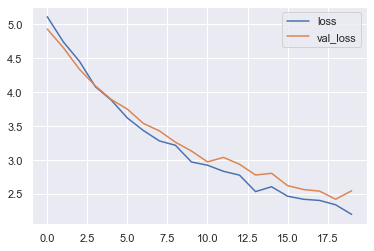

In [75]:
sns.lineplot(data = history_GRU.history['loss'], label='loss')
sns.lineplot(data = history_GRU.history['val_loss'], label='val_loss')

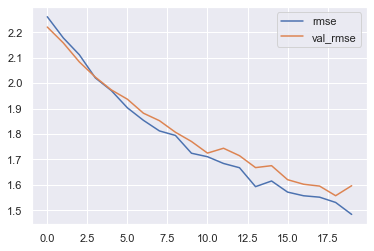

In [76]:
sns.lineplot(data = history_GRU.history['rmse'], label='rmse')
sns.lineplot(data = history_GRU.history['val_rmse'], label='val_rmse')

In [77]:
print('GRU')
print('mse - ' + str(min(history_GRU.history['val_loss'])))
print('rmse - ' + str(min(history_GRU.history['val_rmse'])))

GRU
mse - 2.424898862838745
rmse - 1.5572086572647095


In [78]:
GRU_model = create_GRU()
history_GRU = GRU_model.fit(X_valid, Y_valid, batch_size=4000, epochs = 20)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                12864     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 14,977
Trainable params: 14,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
54/54 [==============================] - 13s 194ms/step - loss: 6.1183 - rmse: 2.3373
Epoch 2/20
54/54 [==============================] - 11s 206ms/step - loss: 5.6297 - rmse: 2.3287
Epoch 3/20
54/54 [==============================] - 11

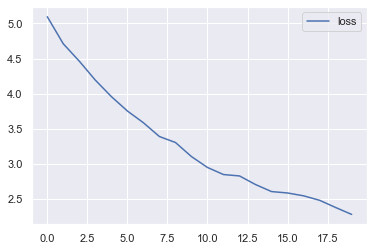

In [79]:
sns.lineplot(data = history_GRU.history['loss'], label='loss')

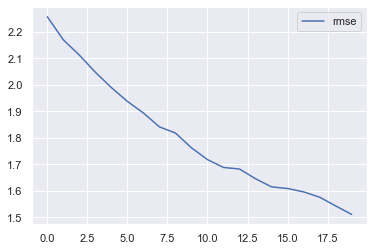

In [80]:
sns.lineplot(data = history_GRU.history['rmse'], label='rmse')

In [81]:
GRU_y = GRU_model.predict(X_test)

In [82]:
LSTM_y = LSTM_y.reshape(214200)
GRU_y = GRU_y.reshape(214200)

In [83]:
del X_train
del X_valid
del Y_train
del Y_valid
del X_test

LSTM_y = LSTM_y.reshape(214200)
GRU_y = GRU_y.reshape(214200)

## Feuture engineering and Light GBM approach

### Categories

In [84]:
new_train = train.groupby(['date_block_num', 'item_id', 'shop_id']).agg({'item_cnt_day': 'sum',
                                                                         'item_category_id':'first'})
new_train.reset_index(inplace=True)

In [85]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

In [86]:
new_train = pd.merge(matrix, new_train, on=['date_block_num', 'item_id', 'shop_id'], how='left')
del matrix

In [87]:
new_train['item_cnt_day'].fillna(0, inplace=True)

In [88]:
new_train = new_train.join(items[['item_id', 'item_category_id']], on='item_id', 
                           how='left', lsuffix='_out').drop(columns=['item_id_out', 'item_category_id_out'])

Distribution plot for whole 'item_cnt_day' column

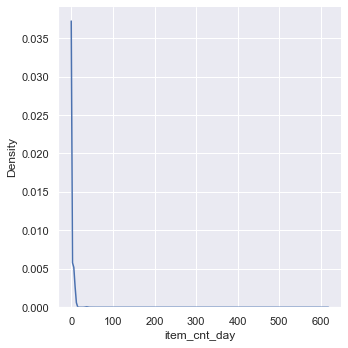

In [89]:
sns.displot(x=new_train['item_cnt_day'], kind='kde')

Distribution plot for 33th month

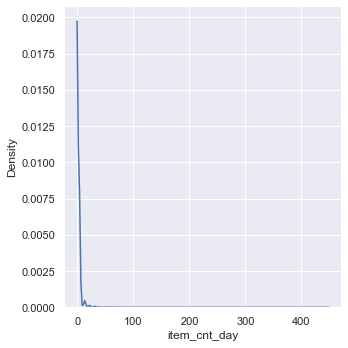

In [90]:
sns.displot(x=new_train.loc[new_train['date_block_num'] == 33, 'item_cnt_day'], kind='kde')

**GBM is sensitive to outliers, so we'll clip counts to (0,20)**

In [91]:
new_train['item_cnt_day'] = np.clip(new_train['item_cnt_day'], 0, 20)

**We'll unite common categories like music(Музыка), presents(Подарки) etc.**

In [92]:
print(item_categories['item_category_name'].to_string())

0                      PC - Гарнитуры/Наушники
1                             Аксессуары - PS2
2                             Аксессуары - PS3
3                             Аксессуары - PS4
4                             Аксессуары - PSP
5                          Аксессуары - PSVita
6                        Аксессуары - XBOX 360
7                        Аксессуары - XBOX ONE
8                               Билеты (Цифра)
9                              Доставка товара
10                       Игровые консоли - PS2
11                       Игровые консоли - PS3
12                       Игровые консоли - PS4
13                       Игровые консоли - PSP
14                    Игровые консоли - PSVita
15                  Игровые консоли - XBOX 360
16                  Игровые консоли - XBOX ONE
17                    Игровые консоли - Прочие
18                                  Игры - PS2
19                                  Игры - PS3
20                                  Игры - PS4
21           

In [93]:
categories = {'Accessories':[i for i in range(0,8)], 'Consoles':[i for i in range(10,18)],
             'Games':[i for i in range(18,32)], 'Pay cards':[i for i in range(32,37)],
             'Movie':[i for i in range(32,42)], 'Books':[i for i in range(42,55)],
              'Music':[i for i in range(55,61)], 'Presents':[i for i in range(61,73)],
             'Programmes':[i for i in range(73,79)], 'Others':[8,9,79,80,81,82,83]
             }

In [94]:
test = test.join(item_categories, on='item_id', how='left')
test['item_category_id'].value_counts(dropna=False)

NaN     213360
53.0        42
32.0        42
33.0        42
67.0        42
62.0        42
69.0        42
70.0        42
72.0        42
64.0        42
31.0        42
51.0        42
38.0        42
80.0        42
57.0        42
83.0        42
42.0        42
59.0        42
30.0        42
45.0        42
76.0        42
Name: item_category_id, dtype: int64

In [95]:
#ALL nans go to Others category
test['item_category_id'].fillna(83, inplace=True)

In [96]:
for key in categories:
    new_train.loc[np.isin(new_train['item_category_id'], categories[key]), 'category'] = key
    test.loc[np.isin(test['item_category_id'], categories[key]), 'category'] = key

### Date features

In [97]:
new_train['month'] = new_train['date_block_num'] % 12
new_train['year'] = new_train['date_block_num'] // 12
test['month'] = 10
test['year'] = 2
test['date_block_num'] = 34

### Shop features

In [98]:
new_train = new_train.join(shops, on='shop_id', how='left', rsuffix='_shp')
test = test.join(shops, on='shop_id', how='left', rsuffix='_shp')

In [99]:
new_train['shop_city'] = new_train['shop_name'].str.split().str[0]
test['shop_city'] = test['shop_name'].str.split().str[0]

In [100]:
new_train.drop(columns = ['item_category_id', 'shop_name', 'shop_id_shp'], inplace=True)
test.drop(columns = ['ID', 'item_category_name', 'item_category_id', 'shop_name', 'shop_id_shp'], inplace=True)

In [101]:
new_train['date_block_num'] = new_train['date_block_num'].astype('int16')
new_train['shop_id'] = new_train['shop_id'].astype('int16')
new_train['item_id'] = new_train['item_id'].astype('int16')
new_train['year'] = new_train['year'].astype('int16')
new_train['month'] = new_train['month'].astype('int16')

### Lag features

**We'll create lags for 1-6, 8, 10, 12 months**

In [102]:
NUMBERS = [1,2,3,4,5,6,12]

def create_lag(data, test, col, numbers):
    for lag in numbers:
        tmp = data[['date_block_num', 'item_id', 'shop_id', col]].copy()
        tmp['date_block_num'] = tmp['date_block_num'].apply(lambda x: x+lag)
        tmp[col + '_lag_' + str(lag)] = tmp[col]
        data = pd.merge(data, tmp[['date_block_num', 'item_id', 'shop_id', col + '_lag_' + str(lag)]],
                       on=['date_block_num','shop_id','item_id'], how='left')
        data[col + '_lag_' + str(lag)] = data[col + '_lag_' + str(lag)].astype('float16')
    for lag in numbers:
        tmp = new_train[['date_block_num', 'item_id', 'shop_id', col]].copy()
        tmp = tmp.loc[tmp['date_block_num'] == 34-lag]
        tmp[col + '_lag_' + str(lag)] = tmp[col]
        test = pd.merge(test, tmp[['item_id', 'shop_id', col + '_lag_' + str(lag)]],
                       on=['shop_id','item_id'], how='left')
        test[col + '_lag_' + str(lag)] = test[col + '_lag_' + str(lag)].astype('float16')
    return data, test

#### item_cnt_day

In [103]:
new_train, test = create_lag(new_train, test, 'item_cnt_day', NUMBERS)

In [104]:
print(new_train.shape)
print(test.shape)

(10913850, 15)
(214200, 14)


### Creating aggregated columns and lags for them

In [105]:
def create_agg(data, by, agg_col, agg_method, new_col):
    tmp = data.groupby(by).agg({agg_col:agg_method})
    tmp[new_col] = tmp[agg_col]
    data = data.join(tmp, on=by, how='left', rsuffix='_out')
    data.drop(columns= agg_col + '_out', inplace=True)
    return data

#### Item month average lags

In [106]:
new_train = create_agg(new_train, ['item_id', 'date_block_num'], 'item_cnt_day', 'mean', 'item_month_avg')

In [107]:
new_train, test = create_lag(new_train, test, 'item_month_avg', NUMBERS)

In [108]:
new_train.drop(columns='item_month_avg', inplace=True)

#### City month average lags

In [109]:
new_train = create_agg(new_train, ['shop_city', 'date_block_num'], 'item_cnt_day', 'mean', 'city_month_avg')

In [110]:
new_train, test = create_lag(new_train, test, 'city_month_avg', NUMBERS)

In [111]:
new_train.drop(columns='city_month_avg', inplace=True)

#### Shop month average lags

In [112]:
new_train = create_agg(new_train, ['shop_id', 'date_block_num'], 'item_cnt_day', 'mean', 'shop_month_avg')

In [113]:
new_train, test = create_lag(new_train, test, 'shop_month_avg', NUMBERS)

In [114]:
new_train.drop(columns='shop_month_avg', inplace=True)

### December (pick sales month) mark feature

In [115]:
new_train['pick_month'] = np.where(new_train['month'] == 11, 1, 0)
test['pick_month'] = 0

In [116]:
new_train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### Trend features (diff)

**Last 5 months**

In [117]:
DIFF_NUMBERS = 5
def create_diff(data, test, col, numbers):
    for i in range(1, numbers+1):
        data[col + '_diff_' + str(i)] = data[col + '_lag_' + str(i+1)] - data[col + '_lag_' + str(i)]
        test[col + '_diff_' + str(i)] = test[col + '_lag_' + str(i+1)] - test[col + '_lag_' + str(i)]
    return data, test

In [118]:
new_train, test = create_diff(new_train, test, 'item_cnt_day', DIFF_NUMBERS)
new_train, test = create_diff(new_train, test, 'shop_month_avg', DIFF_NUMBERS)
new_train, test = create_diff(new_train, test, 'item_month_avg', DIFF_NUMBERS)
new_train, test = create_diff(new_train, test, 'city_month_avg', DIFF_NUMBERS)

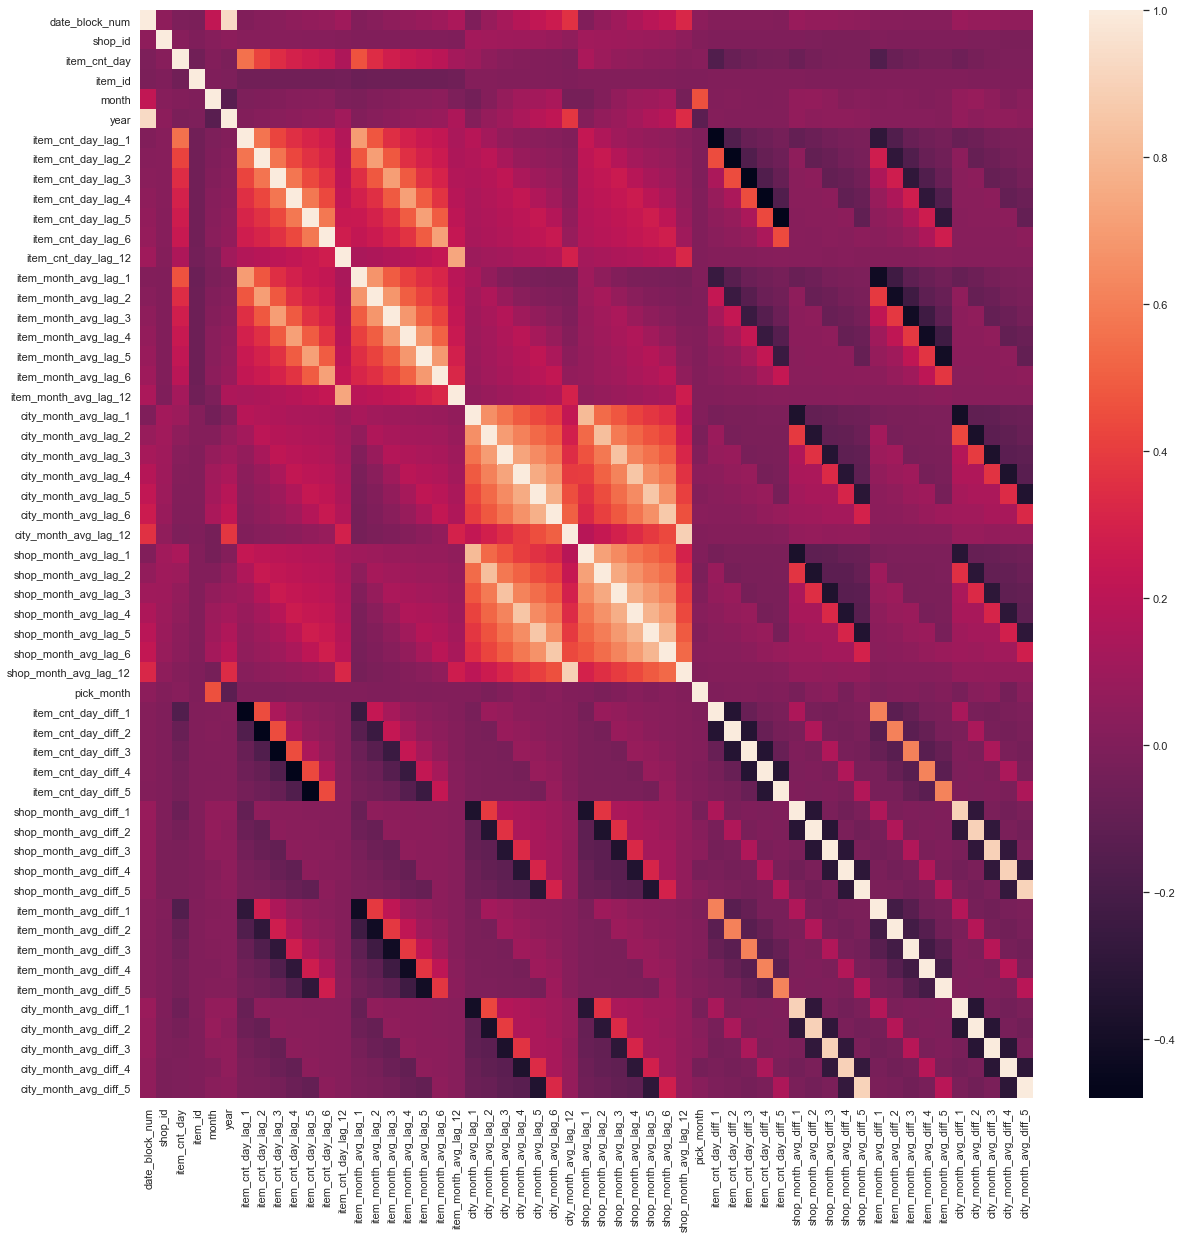

In [119]:
fig, ax = pyplot.subplots(figsize=(20, 20))
sns.heatmap(new_train.corr())

### Creating dataset

In [120]:
new_train = new_train[new_train['date_block_num'] > 11]

In [121]:
encoder = LabelEncoder()
new_train['category'] = encoder.fit_transform(new_train['category'])
test['category'] = encoder.transform(test['category'])
new_train['shop_city'] = encoder.fit_transform(new_train['shop_city'])
test['shop_city'] = encoder.transform(test['shop_city'])
new_train['category'] = new_train['category'].astype('int16')
new_train['shop_city'] = new_train['shop_city'].astype('int16')
test['category'] = test['category'].astype('int16')
test['shop_city'] = test['shop_city'].astype('int16')
new_train['pick_month'] = new_train['pick_month'].astype('int8')
test['pick_month'] = test['pick_month'].astype('int8')

In [122]:
new_train.dtypes

date_block_num             int16
shop_id                    int16
item_cnt_day             float32
item_id                    int16
category                   int16
month                      int16
year                       int16
shop_city                  int16
item_cnt_day_lag_1       float16
item_cnt_day_lag_2       float16
item_cnt_day_lag_3       float16
item_cnt_day_lag_4       float16
item_cnt_day_lag_5       float16
item_cnt_day_lag_6       float16
item_cnt_day_lag_12      float16
item_month_avg_lag_1     float16
item_month_avg_lag_2     float16
item_month_avg_lag_3     float16
item_month_avg_lag_4     float16
item_month_avg_lag_5     float16
item_month_avg_lag_6     float16
item_month_avg_lag_12    float16
city_month_avg_lag_1     float16
city_month_avg_lag_2     float16
city_month_avg_lag_3     float16
city_month_avg_lag_4     float16
city_month_avg_lag_5     float16
city_month_avg_lag_6     float16
city_month_avg_lag_12    float16
shop_month_avg_lag_1     float16
shop_month

In [123]:
X_train = new_train.loc[new_train['date_block_num'] < 33, :].drop(columns='item_cnt_day')
Y_train = new_train.loc[new_train['date_block_num'] < 33, 'item_cnt_day']

X_valid = new_train.loc[new_train['date_block_num'] == 33, :].drop(columns='item_cnt_day')
Y_valid = new_train.loc[new_train['date_block_num'] == 33, 'item_cnt_day']

X_train_test = new_train.drop(columns='item_cnt_day')
Y_train_test = new_train['item_cnt_day']

X_test = test.copy()

In [124]:
print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_train_test.shape, Y_train_test.shape)
print(X_test.shape)

(6186922, 56) (6186922,)
(238172, 56) (238172,)
(6425094, 56) (6425094,)
(214200, 56)


In [125]:
del new_train
del test

### Building a model (LGBM)

In [126]:
train_data = lgb.Dataset(X_train, label=Y_train)
valid_data = lgb.Dataset(X_valid, label=Y_valid, reference=train_data)

In [127]:
evals_result = {}

In [134]:
params = {
    'objective':'regression',
    'max_depth' : 7,
    'num_leaves': 100,
    'num_iterations' : 300,
    'verbosity' : 1,
    'min_data_in_leaf' : 50,
    'feature_fraction' : 1,
    'bagging_fraction' : 1,
    'bagging_freq': 5,
    'metric' : 'rmse',
    'early_stopping_round' : 15,
    'learning_rate' : 0.05,
}

cat_features = ['category', 'shop_city', 'pick_month']

In [135]:
model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1, categorical_feature=cat_features, evals_result=evals_result)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.652319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9905
[LightGBM] [Info] Number of data points in the train set: 6186922, number of used features: 56
[LightGBM] [Info] Start training from score 0.289434
[1]	training's rmse: 1.16554	valid_1's rmse: 1.1207
Training until validation scores don't improve for 15 rounds
[2]	training's rmse: 1.14339	valid_1's rmse: 1.10527
[3]	training's rmse: 1.12306	valid_1's rmse: 1.09123
[4]	training's rmse: 1.10432	valid_1's rmse: 1.07841
[5]	training's rmse: 1.08701	valid_1's rmse: 1.06658
[6]	training's rmse: 1.07102	valid_1's rmse: 1.05581
[7]	training's rmse: 1.05639	valid_1's rmse: 1.04614
[8]	training's rmse: 1.04274	valid_1's rmse: 1.03713
[9]	training's rmse: 1.0303	valid_1's rmse: 1.0292
[10]	training's rmse: 1.01881	valid_1's rmse: 1.02192


[121]	training's rmse: 0.853026	valid_1's rmse: 0.93758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	training's rmse: 0.852898	valid_1's rmse: 0.937559
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	training's rmse: 0.852711	valid_1's rmse: 0.937534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	training's rmse: 0.852526	valid_1's rmse: 0.937608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	training's rmse: 0.852342	valid_1's rmse: 0.937519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	training's rmse: 0.85222	valid_1's rmse: 0.937656
[127]	training's rmse: 0.852059	valid_1's rmse: 0.937659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	training's rmse: 0.851929	valid_1's rmse: 0.937725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	training's rmse

[204]	training's rmse: 0.838683	valid_1's rmse: 0.934996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	training's rmse: 0.838595	valid_1's rmse: 0.934978
Early stopping, best iteration is:
[190]	training's rmse: 0.840443	valid_1's rmse: 0.934683


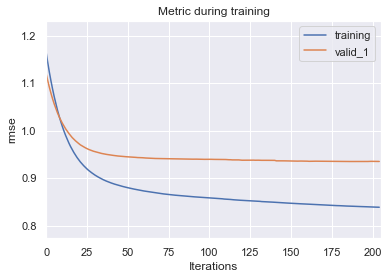

In [136]:
import matplotlib.pyplot as plt
ax = lgb.plot_metric(evals_result)
plt.show()

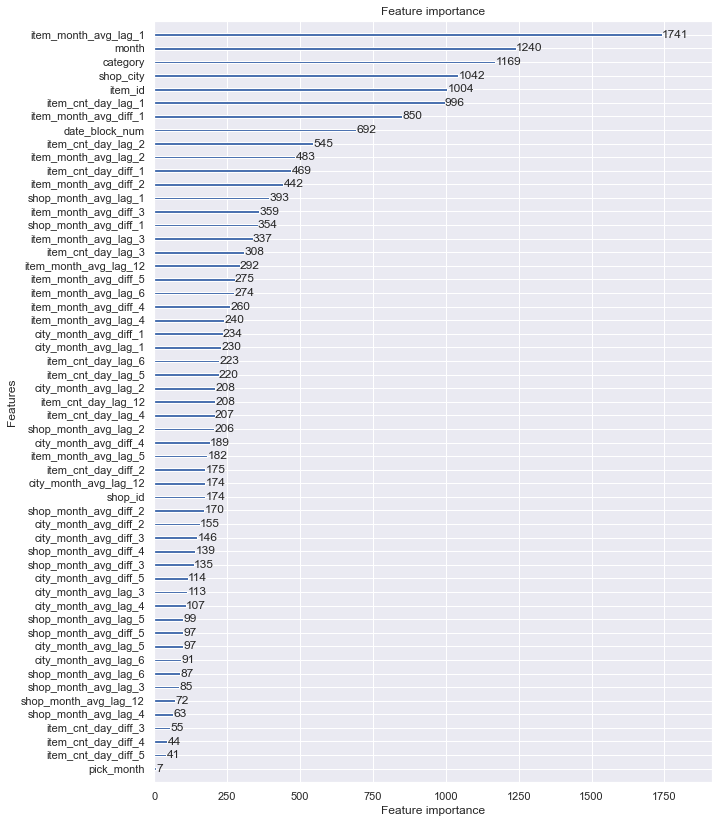

In [137]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

In [138]:
train_data = lgb.Dataset(X_train_test, label=Y_train_test)

In [140]:
params = {
    'objective':'regression',
    'max_depth' : 7,
    'num_leaves': 100,
    'num_iterations' : 190,
    'verbosity' : 1,
    'min_data_in_leaf' : 50,
    'feature_fraction' : 1,
    'bagging_fraction' : 1,
    'bagging_freq': 5,
    'metric' : 'rmse',
    'learning_rate' : 0.05,
}

cat_features = ['category', 'shop_city', 'pick_month']

In [141]:
LGBM_model = lgb.train(params, train_data, verbose_eval=0, categorical_feature=cat_features)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.561234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9907
[LightGBM] [Info] Number of data points in the train set: 6425094, number of used features: 56
[LightGBM] [Info] Start training from score 0.288308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [142]:
LGBM_y = LGBM_model.predict(X_test)

In [143]:
Y = 0.7*LGBM_y + 0.15*LSTM_y + 0.15*GRU_y

In [144]:
print(LGBM_y[:10])
print(LSTM_y[:10])
print(GRU_y[:10])
print(Y[:10])

[0.47177371 0.139845   0.83594653 0.32445688 0.139845   0.46741391
 0.66912627 0.15084808 1.0253546  1.0342286 ]
[0.43534565 0.1008375  0.85324466 0.14802921 0.1008375  0.41983786
 1.0163088  0.13072103 1.0498621  0.1008375 ]
[0.40603983 0.12501988 0.90208876 0.13171595 0.12501988 0.35475212
 0.9573808  0.12438138 1.141462   0.12501988]
[0.45644942 0.13177011 0.84846259 0.26908159 0.13177011 0.44337824
 0.76444184 0.14385902 1.04644685 0.75783863]


In [145]:
sample = pd.read_csv(r'predict_sales/sample_submission.csv')
sample['item_cnt_month'] = LGBM_y
sample.to_csv(path_or_buf=r'predict_sales/submission_LGBM.csv', index=False)
sample['item_cnt_month'] = LSTM_y
sample.to_csv(path_or_buf=r'predict_sales/submission_LSTM.csv', index=False)
sample['item_cnt_month'] = GRU_y
sample.to_csv(path_or_buf=r'predict_sales/submission_GRU.csv', index=False)
sample['item_cnt_month'] = Y
sample.to_csv(path_or_buf=r'predict_sales/submission_Ensemble.csv', index=False)